In [2]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, KFold, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import time
import cudf
from cuml.ensemble import RandomForestRegressor as cuRF
import math
import xgboost as xgb
from tqdm import tqdm

#### Output file

In [9]:
sourceFile = open("gpu_logs/selected_7days.txt", 'w')

### Load the data

In [8]:
df = pd.read_csv("data/porto.csv", decimal=",", index_col=[0])
## Leaving the first house (public building out) due to its different profile
df['Energy'] = df['Energy'].astype(np.float32)
df = df.iloc[35136:, [0, 2, 1]].reset_index(drop=True)
number_of_houses = df.Location.nunique()
df['Time'] = pd.to_datetime(df['Time'])
df.reset_index(drop=True, inplace=True)
df

,Time,Location,Energy
0,2019-01-01 00:00:00,1,2.322959
1,2019-01-01 00:15:00,1,2.371797
2,2019-01-01 00:30:00,1,2.415961
3,2019-01-01 00:45:00,1,2.302538
4,2019-01-01 01:00:00,1,2.363063
...,...,...,...
1756795,2020-01-01 22:45:00,50,0.753222
1756796,2020-01-01 23:00:00,50,0.716855
1756797,2020-01-01 23:15:00,50,0.735802
1756798,2020-01-01 23:30:00,50,0.485237


In [14]:
#trunc = lambda x: math.trunc(10000 * x) / 10000
#df_trunc = pd.DataFrame(df['Energy']).applymap(trunc)
#df = pd.concat([df.iloc[:, 0:-1], df_trunc], axis=1)
#df

### Auxiliary functions

In [3]:
def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()

def truncate_metric(metric):
    m = math.trunc(10000 * metric) / 10000
    return m 
    
def performance_metrics(preds: np.array, actuals: np.array, filename):

    # calculate performance metrics
    
    mse = truncate_metric(mean_squared_error(actuals, preds))
    wape = truncate_metric(np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals))) * 100
    r2 = truncate_metric(r2_score(actuals, preds))
    
    # print performance metrics
    print('MSE: %.4f' % mse, file=filename)
    print('WAPE: %.2f' % wape, file=filename)
    print('R2: %.4f' % r2, file=filename)
    print('MSE: %.4f' % mse)
    print('WAPE: %.2f' % wape)
    print('R2: %.4f' % r2)
    return mse, wape, r2

#@jit(target_backend='cuda')
def build_model(estimator, X_train: np.array, y_train: np.array, X_test: np.array):
    
    model = estimator
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    return model, preds

def validate(estimator, X_train, y_train):
    scores = cross_validate(estimator, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'])
    return scores
    

In [4]:
def total_averaged_metrics(metrics_list, filename):
    
    print("Total Averaged MSE: {}".format(np.round(sum(i for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged WAPE: {}".format(np.round(sum(j for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged R2: {}".format(np.round(sum(k for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged MSE: {}".format(np.round(sum(i for i, j, k in metrics_list)/len(metrics_list),3)))
    print("Total Averaged WAPE: {}".format(np.round(sum(j for i, j, k in metrics_list)/len(metrics_list),3)))
    print("Total Averaged R2: {}".format(np.round(sum(k for i, j, k in metrics_list)/len(metrics_list),3)))

def past_timesteps(df, number_of_timesteps):
    df = df.sort_values(by=['Location', 'Time'])
    for i in tqdm(range(1, (number_of_timesteps + 1))):
        df.loc[df['Time'].shift(i) == df['Time'] - pd.Timedelta(i * 15, 'm'), f"lag_{i}"] = df['Energy'].shift(i)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [5]:
def normalize_training(X_train):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    return X_train, scaler

In [6]:
def test_leave_house_out(df, estimator, locations, filename):
    test = df[df['Location'].isin(locations)]
    train = df[~df['Location'].isin(locations)]
    print("Train set: ", train.shape)
    print("Test set: ", test.shape)
    X_train = train.drop(['Time', 'Energy', 'Location'], axis=1)
    X_test = test.drop(['Time', 'Energy', 'Location'], axis=1)
    y_train = train['Energy']
    y_test = test['Energy']

    X_train_norm, scaler = normalize_training(X_train)
    X_test_norm = scaler.transform(X_test)
    model = estimator
    init = time.time()
    model.fit(X_train_norm, y_train)
    y_pred = model.predict(X_test_norm)
    end = time.time()
    print('Elapsed time: {:.4f} s'.format(end - init), file=filename)
    mse, wape, r2 = performance_metrics(y_pred, y_test.values.reshape(-1), filename)
    return mse, wape, r2, model

## Save Dataframe with past timesteps

In [8]:
number_of_timesteps = 96

In [9]:
df_new = past_timesteps(df, number_of_timesteps)
df_new

100%|██████████| 96/96 [00:00<00:00, 163.39it/s]


,Time,Location,Energy,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_87,lag_88,lag_89,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96
0,2019-01-02 00:00:00,1,0.345928,0.478050,0.350111,0.377052,0.455415,0.349619,0.421338,0.478296,...,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961,2.371797,2.322959
1,2019-01-02 00:15:00,1,0.372131,0.345928,0.478050,0.350111,0.377052,0.455415,0.349619,0.421338,...,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961,2.371797
2,2019-01-02 00:30:00,1,0.521968,0.372131,0.345928,0.478050,0.350111,0.377052,0.455415,0.349619,...,2.443886,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961
3,2019-01-02 00:45:00,1,0.407560,0.521968,0.372131,0.345928,0.478050,0.350111,0.377052,0.455415,...,2.406489,2.443886,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538
4,2019-01-02 01:00:00,1,0.414080,0.407560,0.521968,0.372131,0.345928,0.478050,0.350111,0.377052,...,2.378686,2.406489,2.443886,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455515,2020-01-01 22:45:00,37,2.559163,3.734327,1.542202,1.636871,1.641640,1.588484,3.404035,1.876841,...,3.445410,3.471637,3.678226,2.918065,2.996325,3.661677,2.431955,3.178231,2.557900,2.181046
455516,2020-01-01 23:00:00,37,2.435601,2.559163,3.734327,1.542202,1.636871,1.641640,1.588484,3.404035,...,3.488046,3.445410,3.471637,3.678226,2.918065,2.996325,3.661677,2.431955,3.178231,2.557900
455517,2020-01-01 23:15:00,37,2.499977,2.435601,2.559163,3.734327,1.542202,1.636871,1.641640,1.588484,...,2.883564,3.488046,3.445410,3.471637,3.678226,2.918065,2.996325,3.661677,2.431955,3.178231
455518,2020-01-01 23:30:00,37,1.648652,2.499977,2.435601,2.559163,3.734327,1.542202,1.636871,1.641640,...,3.928995,2.883564,3.488046,3.445410,3.471637,3.678226,2.918065,2.996325,3.661677,2.431955


In [10]:
df_new['DayOfWeek'] = df_new['Time'].dt.dayofweek
df_new['Weekend'] = df_new['Time'].dt.dayofweek.isin([5, 6]).astype(int)
df_new['Hour'] = df_new['Time'].dt.hour
df_new

,Time,Location,Energy,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96,DayOfWeek,Weekend,Hour
0,2019-01-02 00:00:00,1,0.345928,0.478050,0.350111,0.377052,0.455415,0.349619,0.421338,0.478296,...,2.299586,2.334031,2.363063,2.302538,2.415961,2.371797,2.322959,2,0,0
1,2019-01-02 00:15:00,1,0.372131,0.345928,0.478050,0.350111,0.377052,0.455415,0.349619,0.421338,...,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961,2.371797,2,0,0
2,2019-01-02 00:30:00,1,0.521968,0.372131,0.345928,0.478050,0.350111,0.377052,0.455415,0.349619,...,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961,2,0,0
3,2019-01-02 00:45:00,1,0.407560,0.521968,0.372131,0.345928,0.478050,0.350111,0.377052,0.455415,...,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2,0,0
4,2019-01-02 01:00:00,1,0.414080,0.407560,0.521968,0.372131,0.345928,0.478050,0.350111,0.377052,...,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455515,2020-01-01 22:45:00,37,2.559163,3.734327,1.542202,1.636871,1.641640,1.588484,3.404035,1.876841,...,2.918065,2.996325,3.661677,2.431955,3.178231,2.557900,2.181046,2,0,22
455516,2020-01-01 23:00:00,37,2.435601,2.559163,3.734327,1.542202,1.636871,1.641640,1.588484,3.404035,...,3.678226,2.918065,2.996325,3.661677,2.431955,3.178231,2.557900,2,0,23
455517,2020-01-01 23:15:00,37,2.499977,2.435601,2.559163,3.734327,1.542202,1.636871,1.641640,1.588484,...,3.471637,3.678226,2.918065,2.996325,3.661677,2.431955,3.178231,2,0,23
455518,2020-01-01 23:30:00,37,1.648652,2.499977,2.435601,2.559163,3.734327,1.542202,1.636871,1.641640,...,3.445410,3.471637,3.678226,2.918065,2.996325,3.661677,2.431955,2,0,23


In [11]:
df_new.to_csv("data/porto_cluster2_96.csv", index=False)

## Predict  10 folds with 10 random houses for test

In [15]:
df = pd.read_csv("data/porto_oneweek.csv")
df

,Time,Location,Energy,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,energy_lag_5,energy_lag_6,energy_lag_7,...,energy_lag_666,energy_lag_667,energy_lag_668,energy_lag_669,energy_lag_670,energy_lag_671,energy_lag_672,DayOfWeek,Weekend,Hour
0,2019-01-08 00:00:00,1,1.243963,1.362799,1.311378,1.251098,1.477207,1.758796,1.550280,1.795948,...,2.299586,2.334031,2.363063,2.302538,2.415961,2.371797,2.322959,1,0,0
1,2019-01-08 00:15:00,1,1.289234,1.243963,1.362799,1.311378,1.251098,1.477207,1.758796,1.550280,...,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961,2.371797,1,0,0
2,2019-01-08 00:30:00,1,1.253928,1.289234,1.243963,1.362799,1.311378,1.251098,1.477207,1.758796,...,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961,1,0,0
3,2019-01-08 00:45:00,1,1.233753,1.253928,1.289234,1.243963,1.362799,1.311378,1.251098,1.477207,...,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,1,0,0
4,2019-01-08 01:00:00,1,1.287758,1.233753,1.253928,1.289234,1.243963,1.362799,1.311378,1.251098,...,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723195,2020-01-01 22:45:00,50,0.753221,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,0.552398,...,1.710115,1.515524,2.055415,2.535657,1.772034,1.482914,1.723943,2,0,22
1723196,2020-01-01 23:00:00,50,0.716855,0.753221,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,...,2.010091,1.710115,1.515524,2.055415,2.535657,1.772034,1.482914,2,0,23
1723197,2020-01-01 23:15:00,50,0.735802,0.716855,0.753221,1.099100,0.453906,0.481770,0.483173,0.467528,...,1.194125,2.010091,1.710115,1.515524,2.055415,2.535657,1.772034,2,0,23
1723198,2020-01-01 23:30:00,50,0.485237,0.735802,0.716855,0.753221,1.099100,0.453906,0.481770,0.483173,...,0.676236,1.194125,2.010091,1.710115,1.515524,2.055415,2.535657,2,0,23


In [16]:
df_selected = df[["Time","Location","energy_lag_1","energy_lag_2","energy_lag_3","energy_lag_4","energy_lag_96","energy_lag_192","energy_lag_288","energy_lag_384","energy_lag_480","energy_lag_576","energy_lag_672","DayOfWeek","Hour","Energy"]]
df_selected

,Time,Location,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,energy_lag_96,energy_lag_192,energy_lag_288,energy_lag_384,energy_lag_480,energy_lag_576,energy_lag_672,DayOfWeek,Hour,Energy
0,2019-01-08 00:00:00,1,1.362799,1.311378,1.251098,1.477207,1.349390,1.556923,1.070138,0.982795,0.916242,0.345928,2.322959,1,0,1.243963
1,2019-01-08 00:15:00,1,1.243963,1.362799,1.311378,1.251098,1.220344,1.430336,1.457278,4.612334,0.450002,0.372131,2.371797,1,0,1.289234
2,2019-01-08 00:30:00,1,1.289234,1.243963,1.362799,1.311378,0.517908,1.304366,1.992285,4.270957,1.416435,0.521968,2.415961,1,0,1.253928
3,2019-01-08 00:45:00,1,1.253928,1.289234,1.243963,1.362799,0.245668,1.218622,2.743436,2.589786,1.370796,0.407560,2.302538,1,0,1.233753
4,2019-01-08 01:00:00,1,1.233753,1.253928,1.289234,1.243963,0.254402,0.792239,2.213350,2.268585,1.366982,0.414080,2.363063,1,1,1.287758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723195,2020-01-01 22:45:00,50,1.099100,0.453906,0.481770,0.483173,0.641933,0.778195,0.753221,0.641933,0.778195,0.753221,1.723943,2,22,0.753221
1723196,2020-01-01 23:00:00,50,0.753221,1.099100,0.453906,0.481770,0.752850,0.931837,0.716855,0.752850,0.931837,0.716855,1.482914,2,23,0.716855
1723197,2020-01-01 23:15:00,50,0.716855,0.753221,1.099100,0.453906,0.935428,0.937079,0.735802,0.935428,0.937079,0.735802,1.772034,2,23,0.735802
1723198,2020-01-01 23:30:00,50,0.735802,0.716855,0.753221,1.099100,0.715781,0.803087,0.485237,0.715781,0.803087,0.485237,2.535657,2,23,0.485237


In [17]:
df_selected.to_csv("data/porto_final_7days.csv", index=None)

In [18]:
df_test = pd.read_csv("data/porto_final_7days.csv", nrows=100)

float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float32 for c in float_cols}

df = pd.read_csv("data/porto_final_7days.csv", engine='c', dtype=float32_cols)
df

,Time,Location,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,energy_lag_96,energy_lag_192,energy_lag_288,energy_lag_384,energy_lag_480,energy_lag_576,energy_lag_672,DayOfWeek,Hour,Energy
0,2019-01-08 00:00:00,1,1.362799,1.311378,1.251099,1.477207,1.349390,1.556923,1.070138,0.982795,0.916242,0.345928,2.322959,1,0,1.243963
1,2019-01-08 00:15:00,1,1.243963,1.362799,1.311378,1.251099,1.220344,1.430336,1.457278,4.612334,0.450002,0.372131,2.371797,1,0,1.289234
2,2019-01-08 00:30:00,1,1.289234,1.243963,1.362799,1.311378,0.517908,1.304366,1.992285,4.270957,1.416435,0.521968,2.415961,1,0,1.253928
3,2019-01-08 00:45:00,1,1.253928,1.289234,1.243963,1.362799,0.245668,1.218622,2.743436,2.589786,1.370795,0.407560,2.302538,1,0,1.233753
4,2019-01-08 01:00:00,1,1.233753,1.253928,1.289234,1.243963,0.254402,0.792239,2.213350,2.268585,1.366982,0.414080,2.363063,1,1,1.287758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723195,2020-01-01 22:45:00,50,1.099100,0.453906,0.481770,0.483173,0.641933,0.778195,0.753222,0.641933,0.778195,0.753222,1.723943,2,22,0.753222
1723196,2020-01-01 23:00:00,50,0.753222,1.099100,0.453906,0.481770,0.752850,0.931837,0.716855,0.752850,0.931837,0.716855,1.482914,2,23,0.716855
1723197,2020-01-01 23:15:00,50,0.716855,0.753222,1.099100,0.453906,0.935428,0.937079,0.735802,0.935428,0.937079,0.735802,1.772033,2,23,0.735802
1723198,2020-01-01 23:30:00,50,0.735802,0.716855,0.753222,1.099100,0.715781,0.803087,0.485237,0.715781,0.803087,0.485237,2.535657,2,23,0.485237


In [13]:
#df = df[["Time", "Location", "energy_lag_1", "energy_lag_3", "energy_lag_95", "energy_lag_671", "Energy"]]
#df

In [19]:
num_houses_test = 10
locations = []
for i in range(10):
    np.random.seed(i*5)
    l = np.random.choice(df['Location'].unique(), size=num_houses_test, replace=False)
    locations.append(l)
locations

[array([29, 12, 11, 42,  3, 28, 39, 32, 23,  5]),
 array([43, 30,  7, 20, 29, 18,  3, 44,  4, 22]),
 array([38, 24, 45, 43, 48, 21,  4, 31,  8,  7]),
 array([36, 38, 42, 27, 39, 44,  4, 34, 31, 37]),
 array([13, 15,  5,  9, 46,  2, 26, 25, 48, 24]),
 array([37, 47,  8, 42, 18, 15, 35, 34, 46, 40]),
 array([42, 21, 33, 44, 11, 30, 34, 26, 35, 20]),
 array([40, 27, 23, 32, 30, 44, 42, 18, 26, 24]),
 array([34, 30, 50, 39, 46,  1, 19,  5, 12,  3]),
 array([48,  8,  3, 10,  6, 27, 14, 38,  1, 20])]

In [20]:
## Number of NaNs
df.isna().sum().sum()

0

In [21]:
#kf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42) 
#locations = []
#for _, test_index in kf.split(df['Location'].unique()):
#    locations.append(test_index)
#locations

In [22]:
df.Location.value_counts()

1     34464
38    34464
28    34464
29    34464
30    34464
31    34464
32    34464
33    34464
34    34464
35    34464
36    34464
37    34464
39    34464
2     34464
40    34464
41    34464
42    34464
43    34464
44    34464
45    34464
46    34464
47    34464
48    34464
49    34464
27    34464
26    34464
25    34464
24    34464
3     34464
4     34464
5     34464
6     34464
7     34464
8     34464
9     34464
10    34464
11    34464
12    34464
13    34464
14    34464
15    34464
16    34464
17    34464
18    34464
19    34464
20    34464
21    34464
22    34464
23    34464
50    34464
Name: Location, dtype: int64

### Linear Regression

In [23]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(5):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_lr = test_leave_house_out(df, LinearRegression(), locations[i], sourceFile)
    metrics_list_lr.append((mse, wape, r2))


Iteration 0
Train set:  (1378560, 16)
Test set:  (344640, 16)
MSE: 0.3149
WAPE: 32.53
R2: 0.7527

Iteration 1
Train set:  (1378560, 16)
Test set:  (344640, 16)
MSE: 0.1936
WAPE: 32.52
R2: 0.7764

Iteration 2
Train set:  (1378560, 16)
Test set:  (344640, 16)
MSE: 0.1503
WAPE: 32.00
R2: 0.7412

Iteration 3
Train set:  (1378560, 16)
Test set:  (344640, 16)
MSE: 0.1327
WAPE: 30.51
R2: 0.7738

Iteration 4
Train set:  (1378560, 16)
Test set:  (344640, 16)
MSE: 0.2266
WAPE: 31.92
R2: 0.7364


### XGBoost

In [24]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(5):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_xgb = test_leave_house_out(df, xgb.XGBRegressor(tree_method='gpu_hist', seed=0), locations[i], sourceFile)
    metrics_list_xgb.append((mse, wape, r2))


Iteration 0
Train set:  (1378560, 16)
Test set:  (344640, 16)
MSE: 0.2751
WAPE: 30.05
R2: 0.7839

Iteration 1
Train set:  (1378560, 16)
Test set:  (344640, 16)
MSE: 0.1702
WAPE: 30.42
R2: 0.8034

Iteration 2
Train set:  (1378560, 16)
Test set:  (344640, 16)
MSE: 0.1268
WAPE: 29.62
R2: 0.7817

Iteration 3
Train set:  (1378560, 16)
Test set:  (344640, 16)
MSE: 0.1114
WAPE: 27.78
R2: 0.8100

Iteration 4
Train set:  (1378560, 16)
Test set:  (344640, 16)
MSE: 0.1889
WAPE: 28.57
R2: 0.7801


### Random Forest

In [25]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(5):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_rf = test_leave_house_out(df, cuRF(), locations[i], sourceFile)
    metrics_list_rf.append((mse, wape, r2))


Iteration 0
Train set:  (1378560, 16)
Test set:  (344640, 16)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.2323
WAPE: 27.76
R2: 0.8175

Iteration 1
Train set:  (1378560, 16)
Test set:  (344640, 16)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.1567
WAPE: 28.84
R2: 0.8190

Iteration 2
Train set:  (1378560, 16)
Test set:  (344640, 16)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.1088
WAPE: 27.60
R2: 0.8127

Iteration 3
Train set:  (1378560, 16)
Test set:  (344640, 16)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.0854
WAPE: 24.89
R2: 0.8544

Iteration 4
Train set:  (1378560, 16)
Test set:  (344640, 16)
MSE: 0.1385
WAPE: 25.24
R2: 0.8388


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


## Averaged Metrics

In [26]:
print("\n\n\n", file=sourceFile)

In [27]:
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)

Total Averaged MSE: 0.204
Total Averaged WAPE: 31.896
Total Averaged R2: 0.756


In [28]:
print("\nXGBoost", file=sourceFile)
total_averaged_metrics(metrics_list_xgb, sourceFile)

Total Averaged MSE: 0.174
Total Averaged WAPE: 29.288
Total Averaged R2: 0.792


In [29]:
print("\nRandom Forest", file=sourceFile)
total_averaged_metrics(metrics_list_rf, sourceFile)

Total Averaged MSE: 0.144
Total Averaged WAPE: 26.866
Total Averaged R2: 0.828


In [30]:
sourceFile.close()

### Feature Importance

In [31]:
print('XGBoost\n')
for i,v in enumerate(model_xgb.feature_importances_):
    print('Feature: %0d, Score: %.5f' % (i,v))

XGBoost

Feature: 0, Score: 0.82343
Feature: 1, Score: 0.01382
Feature: 2, Score: 0.01529
Feature: 3, Score: 0.00683
Feature: 4, Score: 0.03574
Feature: 5, Score: 0.01852
Feature: 6, Score: 0.01446
Feature: 7, Score: 0.01234
Feature: 8, Score: 0.01029
Feature: 9, Score: 0.01322
Feature: 10, Score: 0.02030
Feature: 11, Score: 0.00552
Feature: 12, Score: 0.01024


In [32]:
model_xgb.feature_importances_

array([0.82342625, 0.01381653, 0.01529352, 0.00682527, 0.03574226,
       0.01851751, 0.01446146, 0.01234416, 0.0102881 , 0.01321812,
       0.02029898, 0.00552365, 0.01024415], dtype=float32)

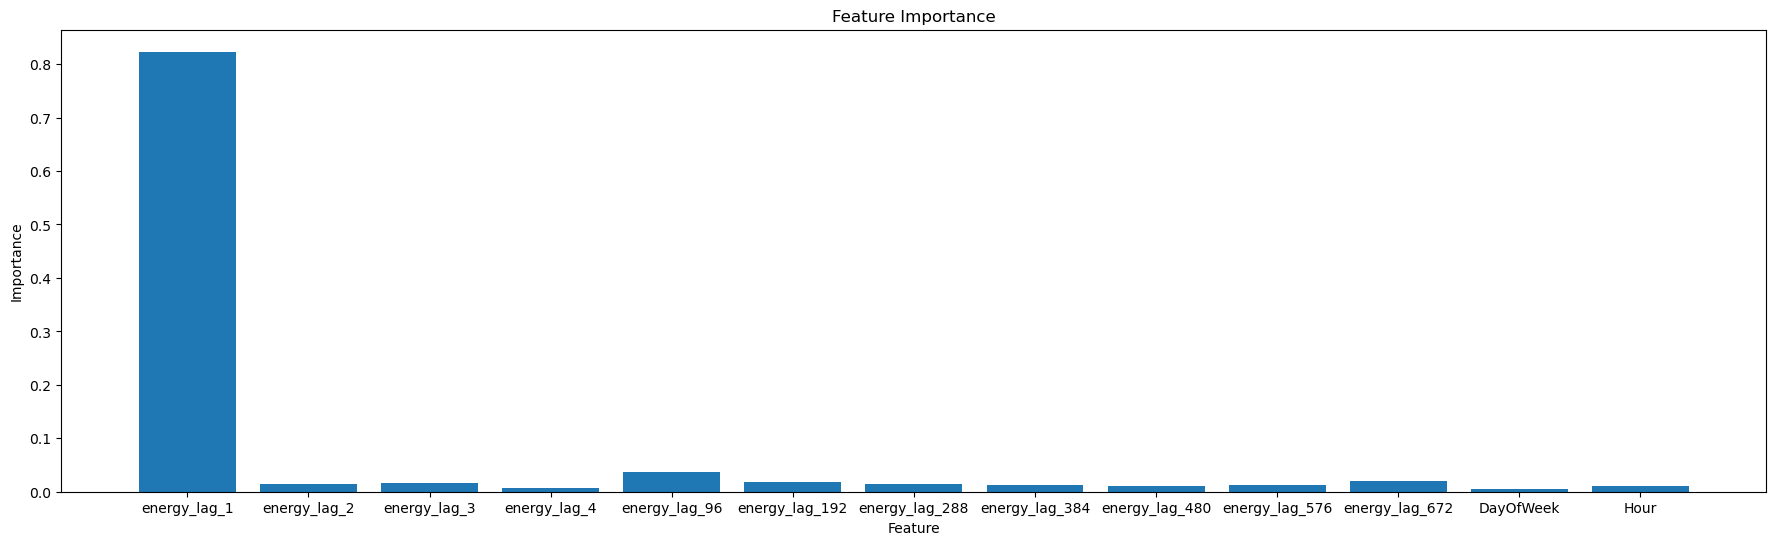

In [39]:
plt.figure(figsize=(22,6))
plt.bar(df.columns[2:-1],model_xgb.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.savefig("images/porto_xgb_final7days_feature_importance.png")
plt.show()

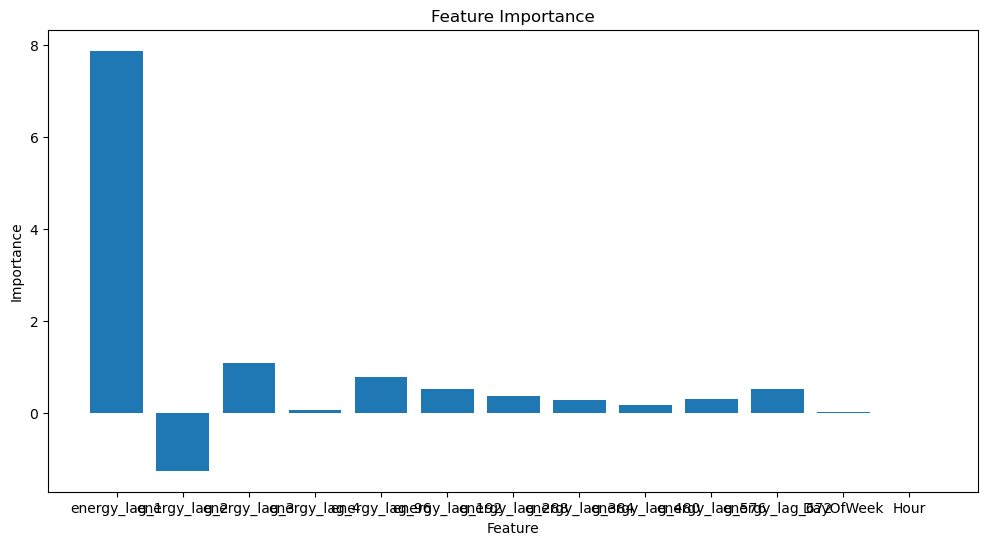

In [34]:
plt.figure(figsize=(12,6))
plt.bar(df.columns[2:-1],model_lr.coef_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [40]:
columns = df.drop(["Energy", "Location", "Time"], axis=1).columns
feature_importance = pd.Series(model_xgb.feature_importances_, index=columns)
feature_importance

lag_1        0.418258
lag_2        0.011936
lag_3        0.016942
lag_4        0.004389
lag_5        0.011281
               ...   
lag_95       0.016826
lag_96       0.021923
DayOfWeek    0.002853
Weekend      0.000000
Hour         0.007056
Length: 99, dtype: float32

In [41]:
features = feature_importance.nlargest(40).index
features

Index(['lag_1', 'lag_93', 'lag_96', 'lag_90', 'lag_3', 'lag_95', 'lag_91',
       'lag_94', 'lag_69', 'lag_28', 'lag_92', 'lag_2', 'lag_5', 'lag_68',
       'lag_6', 'lag_39', 'lag_86', 'lag_29', 'lag_89', 'lag_77', 'Hour',
       'lag_43', 'lag_44', 'lag_33', 'lag_7', 'lag_42', 'lag_87', 'lag_37',
       'lag_82', 'lag_22', 'lag_31', 'lag_62', 'lag_75', 'lag_9', 'lag_12',
       'lag_21', 'lag_8', 'lag_34', 'lag_67', 'lag_30'],
      dtype='object')

In [42]:
df_40 = df[['Time', 'Location'] + [*features] + ['Energy']]
df_40

,Time,Location,lag_1,lag_93,lag_96,lag_90,lag_3,lag_95,lag_91,lag_94,...,lag_62,lag_75,lag_9,lag_12,lag_21,lag_8,lag_34,lag_67,lag_30,Energy
0,2019-01-02 00:00:00,2,0.150346,1.319880,1.544608,0.997031,0.064886,1.544608,0.913154,1.319880,...,0.395647,0.229475,0.363996,0.468447,0.159842,0.378239,2.864487,0.270623,0.634618,0.337092
1,2019-01-02 00:15:00,2,0.337092,0.913154,1.544608,0.997031,0.150346,1.319880,0.997031,1.319880,...,0.395647,0.259545,0.378239,0.468447,0.063304,0.378239,2.864487,0.261127,0.634618,0.337092
2,2019-01-02 00:30:00,2,0.337092,0.913154,1.319880,1.074578,0.150346,1.319880,0.997031,0.913154,...,0.403560,0.259545,0.378239,0.363996,0.063304,0.123442,0.398813,0.261127,0.522255,0.363996
3,2019-01-02 00:45:00,2,0.363996,0.997031,1.319880,1.074578,0.337092,0.913154,1.074578,0.913154,...,0.403560,0.164589,0.123442,0.363996,0.288031,0.123442,0.398813,0.341839,0.522255,0.363996
4,2019-01-02 01:00:00,2,0.363996,0.997031,0.913154,0.508011,0.337092,0.913154,1.074578,0.997031,...,0.259545,0.164589,0.123442,0.378239,0.288031,0.064886,0.634618,0.341839,0.914737,0.278536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296475,2020-01-01 22:45:00,50,1.099100,0.715781,0.641933,0.858855,0.481770,0.752850,0.881889,0.935428,...,1.031567,0.499932,0.533451,0.937120,0.873592,0.533286,0.321565,0.484824,0.335393,0.753222
1296476,2020-01-01 23:00:00,50,0.753222,1.077717,0.752850,1.082588,0.453906,0.935428,0.858855,0.715781,...,0.809237,0.482471,0.533286,0.552398,0.515247,0.552398,0.414113,0.516137,0.467735,0.716855
1296477,2020-01-01 23:15:00,50,0.716855,0.881889,0.935428,1.021784,1.099100,0.715781,1.082588,1.077717,...,0.676029,0.475413,0.552398,0.464143,0.472482,1.001887,0.297128,1.295506,0.285858,0.735802
1296478,2020-01-01 23:30:00,50,0.735802,0.858855,0.715781,1.014065,0.753222,1.077717,1.021784,0.881889,...,0.779599,0.514710,1.001887,0.533451,0.421461,0.467528,1.031650,1.310532,0.605112,0.485237


In [ ]:
df_40.to_csv("data/porto_best40features.csv", index=False)

### Test with 40 best features

In [ ]:
sourceFile = open("gpu_logs/ensemble_porto_40best.txt", 'w')

In [ ]:
df_test = pd.read_csv("data/porto_best40features.csv", nrows=100)

float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float32 for c in float_cols}

df_40 = pd.read_csv("data/porto_best40features.csv", engine='c', dtype=float32_cols)
df_40

In [ ]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_lr = test_leave_house_out(df_40, LinearRegression(), locations[i], sourceFile)
    metrics_list_lr.append((mse, wape, r2))

In [ ]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_xgb = test_leave_house_out(df_40, xgb.XGBRegressor(tree_method='gpu_hist', seed=0), locations[i], sourceFile)
    metrics_list_xgb.append((mse, wape, r2))

In [ ]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_rf = test_leave_house_out(df_40, cuRF(), locations[i], sourceFile)
    metrics_list_rf.append((mse, wape, r2))

In [ ]:
print("\n\n\n", file=sourceFile)

In [ ]:
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)

In [ ]:
print("\nXGBoost", file=sourceFile)
total_averaged_metrics(metrics_list_xgb, sourceFile)

In [ ]:
print("\nRandom Forest", file=sourceFile)
total_averaged_metrics(metrics_list_rf, sourceFile)

In [ ]:
sourceFile.close()